<a href="https://colab.research.google.com/github/PunitRaveendran/ACM/blob/main/Tree-Based%20Models%20%2B%20k-NN%20%2B%20Feature%20Selection%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before Feature Selection:
Decision Tree Accuracy: 1.000
Random Forest Accuracy:  1.000
KNN Accuracy: 0.845


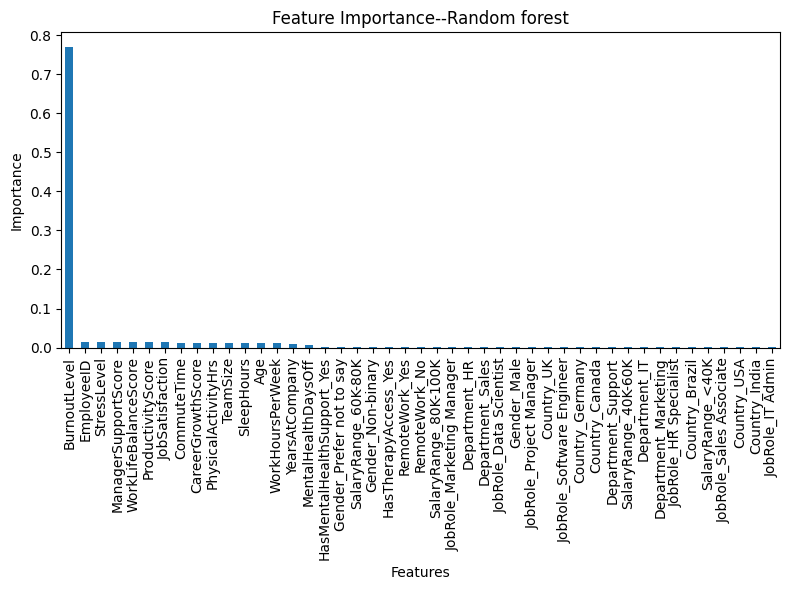

Top 3 features: ['BurnoutLevel', 'EmployeeID', 'StressLevel']
Original columns for top 3 features: ['BurnoutLevel', 'EmployeeID', 'StressLevel']

After Feature Selection - top3:
Decision Tree Accuracy: 1.000
Random Forest Accuracy:  1.000
KNN Accuracy: 0.990
           Model  Before  Accuracy_top3
0  Decision Tree   1.000           1.00
1  Random Forest   1.000           1.00
2            KNN   0.845           0.99


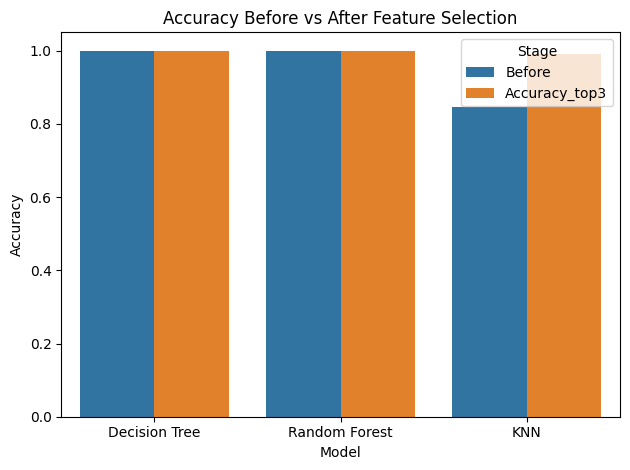

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

df = pd.read_csv('/content/mental_health_workplace_survey.csv')

X = df.drop('BurnoutRisk', axis=1)
y = df['BurnoutRisk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=46, stratify=y
)

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough') # Keep other columns

# Create pipelines for each model
DecisionTree_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=46))])
RandomForest_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=46, n_estimators=150))])
KNN_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier(n_neighbors=10))])

# Train models before feature selection
DecisionTree_pipeline.fit(X_train, y_train)
pred_DecisionTree = DecisionTree_pipeline.predict(X_test)
acc_DecisionTree = accuracy_score(y_test, pred_DecisionTree)

RandomForest_pipeline.fit(X_train, y_train)
pred_random_forest = RandomForest_pipeline.predict(X_test)
acc_random_forest = accuracy_score(y_test, pred_random_forest)

KNN_pipeline.fit(X_train, y_train)
pred_knn = KNN_pipeline.predict(X_test)
acc_knn = accuracy_score(y_test, pred_knn)


print("Before Feature Selection:")
print(f"Decision Tree Accuracy: {acc_DecisionTree:.3f}")
print(f"Random Forest Accuracy:  {acc_random_forest:.3f}")
print(f"KNN Accuracy: {acc_knn:.3f}")

# Between random forest feature importances and Mutual  information we are going with Random forest as they are know to be faster and more intuitive

# Get feature importances from the trained Random Forest model
# Need to access the classifier step of the pipeline
feature_importances = RandomForest_pipeline.named_steps['classifier'].feature_importances_

# Get feature names after one-hot encoding
ohe_feature_names = RandomForest_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = list(ohe_feature_names) + num_cols

imp_features = pd.Series(feature_importances, index=all_feature_names)
imp_features.sort_values(ascending=False).plot(kind='bar',figsize=(8,6))
plt.title('Feature Importance--Random forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

#Selecting the top 3
top3_features = imp_features.nlargest(3).index.tolist()
print(f"Top 3 features: {top3_features}")


# Identify the original columns that correspond to the top 3 features
# This requires mapping back from the processed feature names to the original column names
original_top3_cols = []
for feature in top3_features:
    if feature in num_cols:
        original_top3_cols.append(feature)
    else:
        # Find the original categorical column that resulted in this one-hot encoded feature
        for col in cat_cols:
            if feature.startswith(col + '_'):
                if col not in original_top3_cols:
                    original_top3_cols.append(col)
                break

print(f"Original columns for top 3 features: {original_top3_cols}")

# Retrain with the top 3 original features only
X_train_top3_orig = X_train[original_top3_cols]
X_test_top3_orig = X_test[original_top3_cols]


# Create a new preprocessor for the top 3 original features
# Identify categorical and numerical columns within the top 3 original features
top3_cat_cols_orig = X_train_top3_orig.select_dtypes(exclude=[np.number]).columns.tolist()
top3_num_cols_orig = X_train_top3_orig.select_dtypes(include=[np.number]).columns.tolist()


preprocessor_top3 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), top3_cat_cols_orig),
        ('num', StandardScaler(), top3_num_cols_orig)
    ],
    remainder='passthrough') # Keep other columns


# Create pipelines for each model with top 3 original features
DecisionTree_pipeline_top3 = Pipeline(steps=[('preprocessor', preprocessor_top3), ('classifier', DecisionTreeClassifier(random_state=46))])
RandomForest_pipeline_top3 = Pipeline(steps=[('preprocessor', preprocessor_top3), ('classifier', RandomForestClassifier(random_state=46, n_estimators=150))])
KNN_pipeline_top3 = Pipeline(steps=[('preprocessor', preprocessor_top3), ('classifier', KNeighborsClassifier(n_neighbors=10))])


#Train models with top 3 original features
DecisionTree_pipeline_top3.fit(X_train_top3_orig, y_train)
pred_DecisionTree2 = DecisionTree_pipeline_top3.predict(X_test_top3_orig)
acc_DecisionTree2 = accuracy_score(y_test, pred_DecisionTree2)

RandomForest_pipeline_top3.fit(X_train_top3_orig, y_train)
pred_random_forest2 = RandomForest_pipeline_top3.predict(X_test_top3_orig)
acc_random_forest2 = accuracy_score(y_test, pred_random_forest2)

KNN_pipeline_top3.fit(X_train_top3_orig, y_train)
pred_knn2 = KNN_pipeline_top3.predict(X_test_top3_orig)
acc_knn2 = accuracy_score(y_test, pred_knn2)


print("\nAfter Feature Selection - top3:")
print(f"Decision Tree Accuracy: {acc_DecisionTree2:.3f}")
print(f"Random Forest Accuracy:  {acc_random_forest2:.3f}")
print(f"KNN Accuracy: {acc_knn2:.3f}")

#Conclusion and comparision
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'KNN'],
    'Before': [acc_DecisionTree, acc_random_forest, acc_knn],
    'Accuracy_top3': [acc_DecisionTree2, acc_random_forest2, acc_knn2]
})
print(results)

results_melted = results.melt(id_vars='Model', var_name='Stage', value_name='Accuracy')
sns.barplot(data=results_melted, x='Model', y='Accuracy', hue='Stage')
plt.title('Accuracy Before vs After Feature Selection')
plt.tight_layout()
plt.show()